In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(2020)

In [2]:
def generate_noise_1d(power, smoothness=0.6):
    size = 2 ** power
    scale = 1
    
    noise = np.random.rand(size)
    noise_res = noise.copy()
    
    while size > 1:
        size = size // 2
        scale = scale * 2
        
        noise_mean = np.repeat(np.mean(noise.reshape(size, scale), axis=1), scale)
        noise_mean_conv = np.roll(noise_mean, -scale)
        
        noise_linear = np.tile(np.linspace(0.0, 1.0, scale, endpoint=False), size)
        
        noise_added = (1 - noise_linear) * noise_mean + noise_linear * noise_mean_conv
        
        noise_res = (1 - smoothness) * noise_res + smoothness * noise_added
    
    noise_min = np.min(noise_res)
    noise_max = np.max(noise_res)
    
    return (noise_res - noise_min) / (noise_max - noise_min)

def generate_noise_2d(power, smoothness=0.6):
    size = 2 ** power
    scale = 1
    
    noise = np.random.rand(size, size)
    noise_res = noise.copy()
    
    while size % 2 == 0:
        size = size // 2
        scale = scale * 2
        
        noise_mean = np.repeat(np.repeat(np.mean(noise.reshape(size, size, scale, scale), axis=(2, 3)), scale, axis=0), scale, axis=1)
        noise_mean_convx = np.roll(noise_mean, (-scale, 0), axis=(0, 1))
        noise_mean_convy = np.roll(noise_mean, (0, -scale), axis=(0, 1))
        noise_mean_convxy = np.roll(noise_mean, (-scale, -scale), axis=(0, 1))
        
        noise_linear = np.linspace(0.0, 1.0, scale, endpoint=False)
        noise_linear_x = np.tile(noise_linear[:, np.newaxis], (size, 2 ** power))
        noise_linear_y = np.tile(noise_linear[np.newaxis, :], (2 ** power, size))
        
        noise_added = (
            (1 - noise_linear_x) * (1 - noise_linear_y) * noise_mean +
            noise_linear_x * (1 - noise_linear_y) * noise_mean_convx +
            (1 - noise_linear_x) * noise_linear_y * noise_mean_convy +
            noise_linear_x * noise_linear_y * noise_mean_convxy)
        
        noise_res = (1 - smoothness) * noise_res + smoothness * noise_added
    
    noise_min = np.min(noise_res)
    noise_max = np.max(noise_res)
    
    return (noise_res - noise_min) / (noise_max - noise_min)

In [3]:
def is_inbounds(hmap, x, y):
    return (
        x >= 0.0 and
        y >= 0.0 and
        x < hmap.shape[0] - 1.0 and
        y < hmap.shape[1] - 1.0
    )

def value_at(hmap, x, y):
    if is_inbounds(hmap, x, y):
        xc = int(x)
        yc = int(y)
        
        u = x % 1.0
        v = y % 1.0
        ui = 1.0 - u
        vi = 1.0 - v
        
        return (
            ui * vi * hmap[xc, yc] +
            u * vi * hmap[xc+1, yc] +
            ui * v * hmap[xc, yc+1] +
            u * v * hmap[xc+1, yc+1]
        )
    else:
        return 0
    
def grad_at(hmap, x, y):
    if is_inbounds(hmap, x, y):
        xc = int(x)
        yc = int(y)
        
        u = x % 1.0
        v = y % 1.0
        
        z = hmap[xc, yc]
        zx = hmap[xc+1, yc]
        zy = hmap[xc, yc+1]
        zxy = hmap[xc+1, yc+1]
        
        return np.array([
            (zx - z) + v * (z - zx + zxy - zy),
            (zy - z) + u * (z - zy + zxy - zx)
        ])
    else:
        return 0
    
def iter_grad(hmap, x, y, n_iter=512, rate=1.0):
    n = 0
    pos = []
    while is_inbounds(hmap, x, y) and n < n_iter:
        z = value_at(hmap, x, y)
        g = grad_at(hmap, x, y)
        pos.append((x, y, z))
        
        x = x - rate * g[0]
        y = y - rate * g[1]
        
        n += 1
    return np.array(pos)

In [8]:
x2d = generate_noise_2d(8, smoothness=0.85)

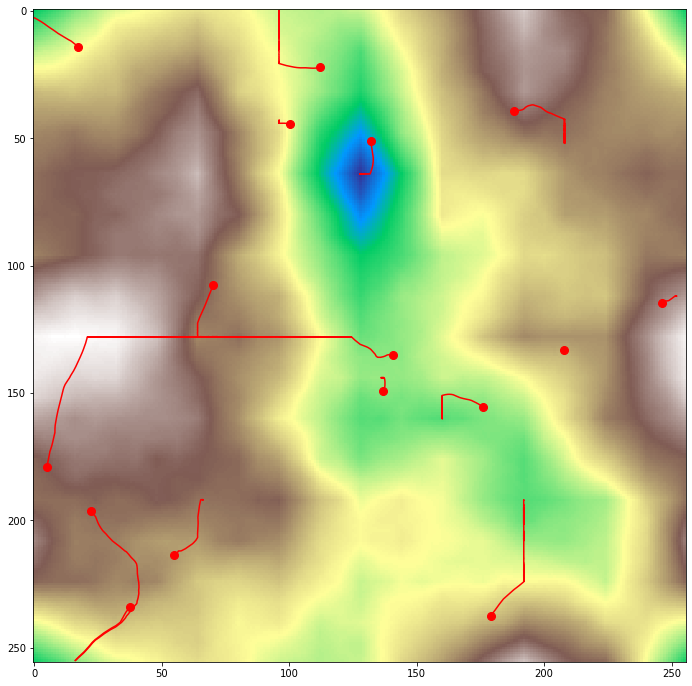

In [14]:
%matplotlib inline

plt.figure(figsize=(12, 12))
plt.imshow(x2d, cmap='terrain')

for k in range(16):
    xr = x2d.shape[0] * np.random.rand()
    yr = x2d.shape[1] * np.random.rand()
    p = iter_grad(x2d, xr, yr, n_iter=2**16, rate=8)

    plt.plot([p[0, 0]], [p[0, 1]], 'or', ms=8)
    plt.plot(p[:, 0], p[:, 1], '-r')
plt.show()

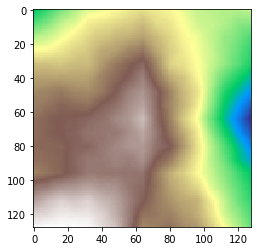

In [17]:
plt.imshow(x2d[:128, :128], cmap='terrain')
plt.show()

<IPython.core.display.Javascript object>


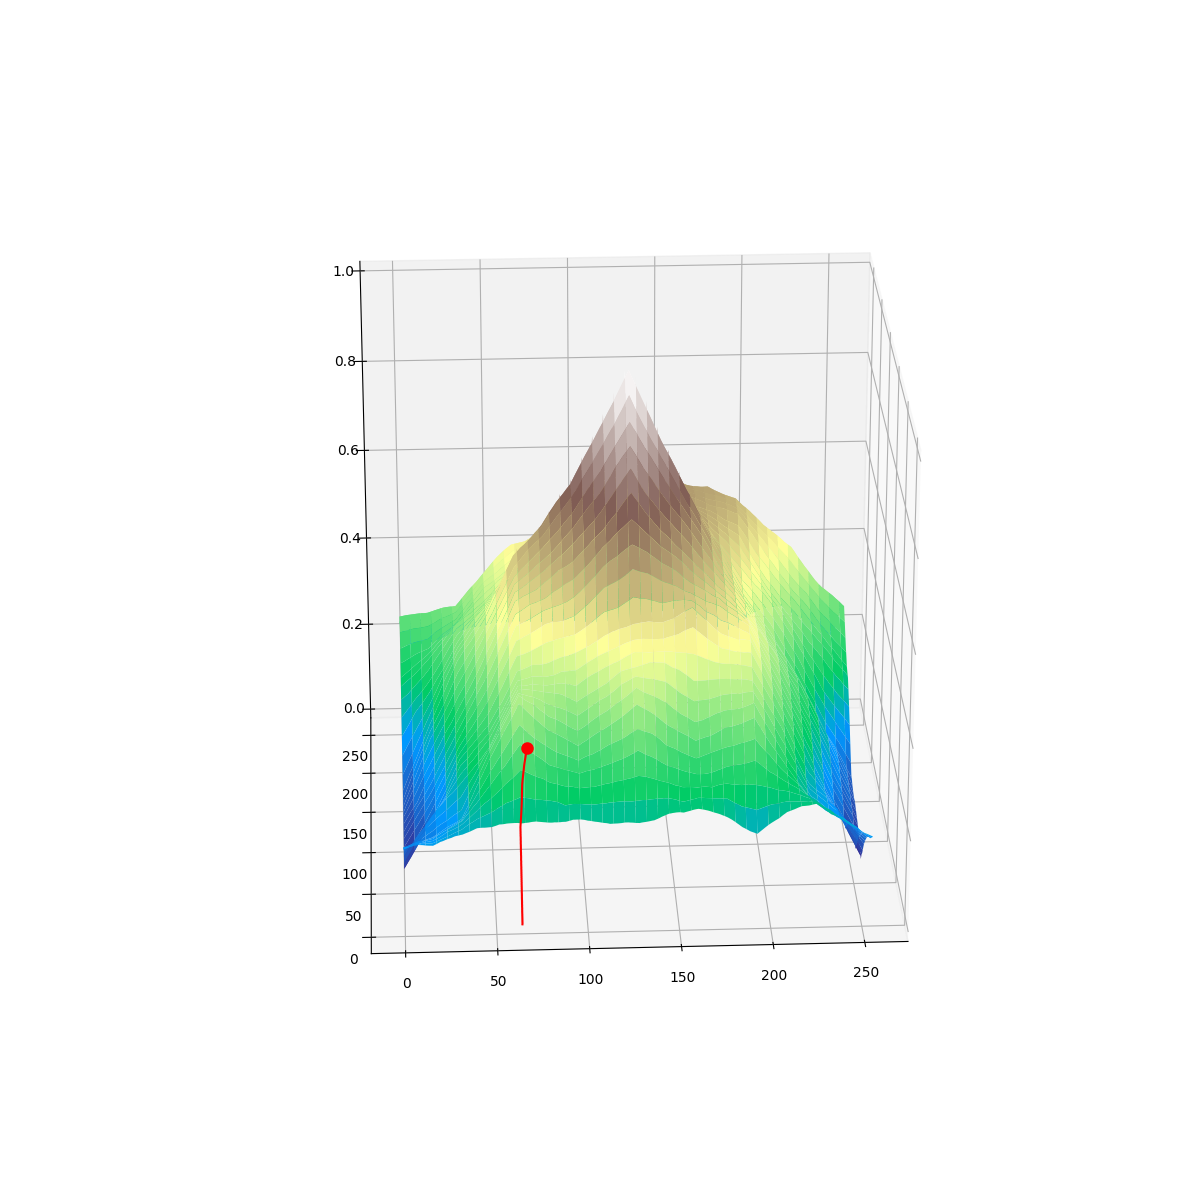

In [6]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

t = np.arange(x2d.shape[0])
xx, yy = np.meshgrid(t, t)

ax.plot([p[0, 0]], [p[0, 1]], [p[0, 2]], 'or', ms=8, zorder=10)
ax.plot(p[:, 0], p[:, 1], p[:, 2], '-r', zorder=10)
ax.plot_surface(xx, yy, x2d, cmap='terrain')
plt.show()